+source: https://colab.research.google.com/github/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial11/Tutorial11.ipynb

# Tutorial 11: DeepWalk and node2vec - Implementation details
  

Paper:
* [DeepWalk: Online Learning of Social Representation](https://arxiv.org/pdf/1403.6652.pdf)  
* [node2vec: Scalable Feature Learning for Networks](https://arxiv.org/pdf/1607.00653.pdf)  

Code:

 * [node2vec doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=node2vec#torch_geometric.nn.models.Node2Vec)
 * [node2vec code](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/node2vec.html)
 * [Example on clustering](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/node2vec.py)

# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [3]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 100})'''))

import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

<IPython.core.display.Javascript object>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 35.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 39.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 28.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 709 kB 16.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.d

In [4]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
import numpy as np

In [5]:
# dataset = 'Cora'
# path = osp.join('.', 'data', dataset)
# dataset = Planetoid(path, dataset)
# data = dataset[0]
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

Processing...
Done!


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, 
                 walk_length=20,                        # lenght of rw
                 context_size=10, walks_per_node=20,
                 num_negative_samples=1, 
                 p=200, q=1,                             # bias parameters
                 sparse=True).to(device)

In [7]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

# Random walks

### The data loader

In [8]:
# loader = model.loader(batch_size=128, shuffle=True, num_workers=4)

# Training

### Model definition

In [9]:
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=10, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

### Training function

In [10]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

### Test function

In [11]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [12]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [13]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [14]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    # return z
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

# z = test()

In [15]:
@torch.no_grad()
def test2():
    model.eval()
    out = model()

    true2 = 0

    acc2 = -1

    #acc1: simple format
    pred = out.argmax(dim=1)  # Use the class with highest probability.

    data.cuda()

    bad = 0
    good = 0

    #acc2: weighted_avg_arg_max:
    for clas in redunclass:
        a = out[clas[0]]
        a = torch.tensor(a, requires_grad=True)
        acctemp = 0
        d = 1
        for clasi in clas[1:]:
            out[clasi] = torch.tensor(out[clasi], requires_grad=True)
            a += out[clasi]
            d+=1
        a/=d
        
        try:
            out[data.test_mask][clas[0]] = d
            temp2 = model.test(out[data.train_mask], data.y[data.train_mask],
                        out[data.test_mask][clas[0]:clas[0]+1], data.y[data.test_mask][clas[0]:clas[0]+1],
                        max_iter=150)
            acctemp += temp2
                
            if acctemp:
                true2 += 1
            good+=1
        except:
            bad+=1

    acc2 = true2/good

    print(bad,good,acc2)
    return(acc2)

### Training

In [16]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

acclist1 = []


for epoch in tqdm(range(1, 101)):
    loss = train()
    acc = test()
    acclist1.append(acc)
    if epoch%10==0 or epoch==1:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

<IPython.core.display.Javascript object>

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01, Loss: 8.0202, Acc: 0.1710
Epoch: 10, Loss: 1.4542, Acc: 0.5290
Epoch: 20, Loss: 0.9247, Acc: 0.6700
Epoch: 30, Loss: 0.8583, Acc: 0.6890
Epoch: 40, Loss: 0.8386, Acc: 0.7050
Epoch: 50, Loss: 0.8300, Acc: 0.7060
Epoch: 60, Loss: 0.8260, Acc: 0.7120
Epoch: 70, Loss: 0.8248, Acc: 0.7120
Epoch: 80, Loss: 0.8234, Acc: 0.7180
Epoch: 90, Loss: 0.8222, Acc: 0.7150
Epoch: 100, Loss: 0.8221, Acc: 0.7090


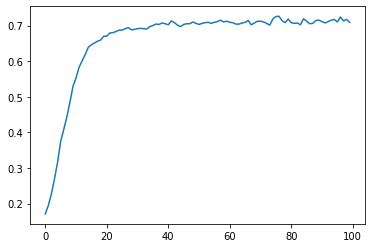

In [17]:
plt.plot(range(len(acclist1)),acclist1)

# change data based on breaking nodes

In [18]:
def multiappender(l,e):
    d = e.reshape(1,-1)
    l = torch.cat([l, torch.tensor(d)], dim=0)
    return l
def appender(l,e):
    z = torch.cat([l, torch.tensor(e).reshape(1)], dim=0)
    return z

In [19]:

def make_data_ready(flag_type_2 = True,
                    each_part_size = 100,
                    istype2 = True):
    
    dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
    data = dataset[0]
    
    redunclass = [[i] for i in range(len(data.x))]

    nodes = np.zeros(len(data.x))
    for i in range(len(data.edge_index[0])):
        a =  data.edge_index[0][i]
        b =  data.edge_index[1][i]
        nodes[a]+=1
        nodes[b]+=1

    strongs = []
    for i in tqdm(range(len(nodes))):
        if nodes[i]>each_part_size:
            strongs.append(i)

    x = data.x
    ei = data.edge_index 
    y = data.y
    train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask
    
    d = False  

    for s in tqdm(strongs):
        n = nodes[s]
        while(n>each_part_size):

            x = multiappender(x,x[s])
            redunclass[s].append(len(x)-1)
            y = appender(y,y[s])

            train_mask = appender(train_mask,train_mask[s])
            val_mask = appender(val_mask,val_mask[s]) 
            
            if istype2:
                test_mask = appender(test_mask,False)
                test_mask[s] = False
            else:
                test_mask = appender(test_mask,test_mask[s])
            
            if n >= each_part_size*1.5:
                t = each_part_size
                n-=t
                
                for i in range(len(ei[0])):
                    e1,e2 = ei[0][i],ei[1][i]
                    
                    if t<=0:
                        break

                    if e1==s:
                        t-=1
                        ei[0][i] = len(val_mask)-1
                    elif e2==s:
                        t-=1
                        ei[1][i] = len(val_mask)-1
                    
            else:
                t = int((n+1)/2)
                n-=t
                
                for i in range(len(ei[0])):
                    if t<=0:
                        break

                    e1,e2 = ei[0][i],ei[1][i]
                    if e1==s:
                        t-=1
                        ei[0][i] = len(val_mask)-1
                    elif e2==s:
                        t-=1
                        ei[1][i] = len(val_mask)-1
                    
            if flag_type_2:

                print(len(data.edge_index[0]),len(data.x),len(ei))

                d = torch.tensor([len(val_mask)-1,s])
                d = d.reshape(2,-1)
                ei = torch.cat([ei, torch.tensor(d)], dim=-1)

                d = torch.tensor([s,len(val_mask)-1])
                d = d.reshape(2,-1)
                ei = torch.cat([ei, torch.tensor(d)], dim=-1)
    data.x = x
    data.edge_index = ei 
    data.y = y
    data.train_mask, data.val_mask, data.test_mask = train_mask, val_mask, test_mask

    nodes = np.zeros(len(data.x))
    for i in range(len(data.edge_index[0])):
        a =  data.edge_index[0][i]
        b =  data.edge_index[1][i]
        nodes[a]+=1
        nodes[b]+=1

    return x,ei,y,d,strongs,nodes,data,train_mask,test_mask,val_mask,dataset,redunclass

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


<IPython.core.display.Javascript object>

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01, Loss: 7.9277, Acc: 0.1532
1709 999 0.17317317317317318
1709 999 0.2702702702702703
1709 999 0.35235235235235235
1709 999 0.4174174174174174
1709 999 0.4864864864864865
Epoch: 10, Loss: 1.4132, Acc: 0.4865
1709 999 0.5455455455455456
1709 999 0.5765765765765766
1709 999 0.6016016016016016
1709 999 0.6246246246246246
1709 999 0.6406406406406406
Epoch: 20, Loss: 0.9152, Acc: 0.6406
1709 999 0.6456456456456456
1709 999 0.6536536536536537
1709 999 0.6646646646646647
1709 999 0.6696696696696697
1709 999 0.6686686686686687
Epoch: 30, Loss: 0.8520, Acc: 0.6687
1709 999 0.6746746746746747
1709 999 0.6766766766766766
1709 999 0.6836836836836837
1709 999 0.6826826826826827
1709 999 0.6886886886886887
Epoch: 40, Loss: 0.8345, Acc: 0.6887
1709 999 0.6906906906906907
1709 999 0.6966966966966966
1709 999 0.6996996996996997
1709 999 0.6966966966966966
1709 999 0.6916916916916916
Epoch: 50, Loss: 0.8262, Acc: 0.6917
1709 999 0.6926926926926927
1709 999 0.6886886886886887
1709 999 0.699699699

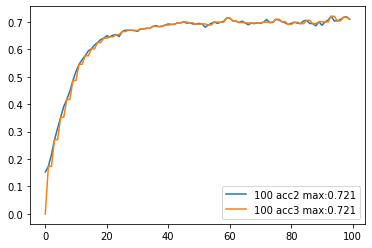

In [20]:
each_part_size = 100

x,ei,y,d,strongs,nodes,data,train_mask,test_mask,val_mask,dataset,redunclass = make_data_ready(flag_type_2 = True,
                                                                                       each_part_size = each_part_size,
                                                                                       istype2 = True)
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=10, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

acclist2 = []
acclist3 = []

acc3 = 0

for epoch in tqdm(range(1, 101)):
    loss = train()
    acc = test()
    acclist2.append(acc)

    if epoch % 2 == 0:
        acc3 = test2()
    acclist3.append(acc3)
    

    if epoch%10==0 or epoch==1:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')


# plt.plot(range(len(acclist1)),acclist1,label='acc1 max:'+str(round(max(acclist1),3)))
plt.plot(range(len(acclist2)),acclist2,label='100 acc2 max:'+str(round(max(acclist2),3)))
plt.plot(range(len(acclist3)),acclist3,label='100 acc3 max:'+str(round(max(acclist3),3)))

plt.legend()

  0%|          | 0/2708 [00:00<?, ?it/s]

0it [00:00, ?it/s]

<IPython.core.display.Javascript object>

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01, Loss: 8.0279, Acc: 0.1410
1708 1000 0.164
1708 1000 0.242
1708 1000 0.32
1708 1000 0.378
1708 1000 0.444
Epoch: 10, Loss: 1.4555, Acc: 0.4440
1708 1000 0.51
1708 1000 0.573
1708 1000 0.613
1708 1000 0.652
1708 1000 0.673
Epoch: 20, Loss: 0.9265, Acc: 0.6730
1708 1000 0.676
1708 1000 0.681
1708 1000 0.686
1708 1000 0.687
1708 1000 0.693
Epoch: 30, Loss: 0.8576, Acc: 0.6930
1708 1000 0.698
1708 1000 0.702
1708 1000 0.697
1708 1000 0.698
1708 1000 0.701
Epoch: 40, Loss: 0.8387, Acc: 0.7010
1708 1000 0.704
1708 1000 0.704
1708 1000 0.713
1708 1000 0.714
1708 1000 0.71
Epoch: 50, Loss: 0.8307, Acc: 0.7100
1708 1000 0.713
1708 1000 0.716
1708 1000 0.713
1708 1000 0.712
1708 1000 0.721
Epoch: 60, Loss: 0.8265, Acc: 0.7210
1708 1000 0.728
1708 1000 0.72
1708 1000 0.72
1708 1000 0.717
1708 1000 0.717
Epoch: 70, Loss: 0.8244, Acc: 0.7170
1708 1000 0.716
1708 1000 0.714
1708 1000 0.714
1708 1000 0.714
1708 1000 0.719
Epoch: 80, Loss: 0.8234, Acc: 0.7190
1708 1000 0.715
1708 1000 0.715


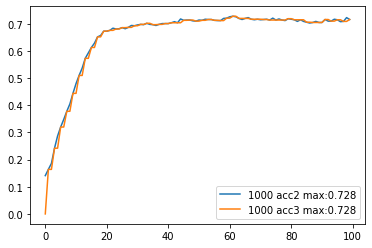

In [21]:
each_part_size = 1000

x,ei,y,d,strongs,nodes,data,train_mask,test_mask,val_mask,dataset,redunclass = make_data_ready(flag_type_2 = True,
                                                                                       each_part_size = each_part_size,
                                                                                       istype2 = True)
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=10, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

acclist2000 = []
acclist3000 = []

acc3 = 0

for epoch in tqdm(range(1, 101)):
    loss = train()
    acc = test()
    acclist2000.append(acc)

    if epoch % 2 == 0:
        acc3 = test2()
    acclist3000.append(acc3)
    

    if epoch%10==0 or epoch==1:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')


plt.plot(range(len(acclist2000)),acclist2000,label='1000 acc2 max:'+str(round(max(acclist2000),3)))
plt.plot(range(len(acclist3000)),acclist3000,label='1000 acc3 max:'+str(round(max(acclist3000),3)))

plt.legend()

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2
10556 2708 2


<IPython.core.display.Javascript object>

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01, Loss: 8.0250, Acc: 0.1427
1713 995 0.16482412060301507
1713 995 0.24020100502512562
1713 995 0.3075376884422111
1713 995 0.3778894472361809
1713 995 0.4562814070351759
Epoch: 10, Loss: 1.4268, Acc: 0.4563
1713 995 0.5165829145728643
1713 995 0.5577889447236181
1713 995 0.5879396984924623
1713 995 0.6060301507537689
1713 995 0.6190954773869347
Epoch: 20, Loss: 0.9166, Acc: 0.6191
1713 995 0.6231155778894473
1713 995 0.6351758793969849
1713 995 0.6462311557788945
1713 995 0.6472361809045226
1713 995 0.6492462311557788
Epoch: 30, Loss: 0.8503, Acc: 0.6492
1713 995 0.6592964824120603
1713 995 0.6653266331658292
1713 995 0.6552763819095477
1713 995 0.6633165829145728
1713 995 0.6673366834170854
Epoch: 40, Loss: 0.8309, Acc: 0.6673
1713 995 0.664321608040201
1713 995 0.6683417085427136
1713 995 0.6733668341708543
1713 995 0.6824120603015076
1713 995 0.6733668341708543
Epoch: 50, Loss: 0.8229, Acc: 0.6734
1713 995 0.6723618090452261
1713 995 0.678391959798995
1713 995 0.68341708542

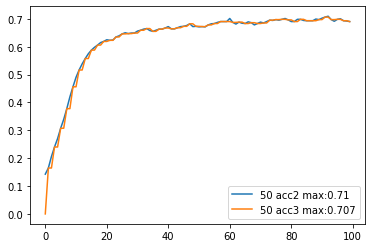

In [22]:
each_part_size = 50

x,ei,y,d,strongs,nodes,data,train_mask,test_mask,val_mask,dataset,redunclass = make_data_ready(flag_type_2 = True,
                                                                                       each_part_size = each_part_size,
                                                                                       istype2 = True)
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=10, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

acclist250 = []
acclist350 = []

acc3 = 0

for epoch in tqdm(range(1, 101)):
    loss = train()
    acc = test()
    acclist250.append(acc)

    if epoch % 2 == 0:
        acc3 = test2()
    acclist350.append(acc3)
    

    if epoch%10==0 or epoch==1:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')


plt.plot(range(len(acclist250)),acclist250,label='50 acc2 max:'+str(round(max(acclist250),3)))
plt.plot(range(len(acclist350)),acclist350,label='50 acc3 max:'+str(round(max(acclist350),3)))

plt.legend()

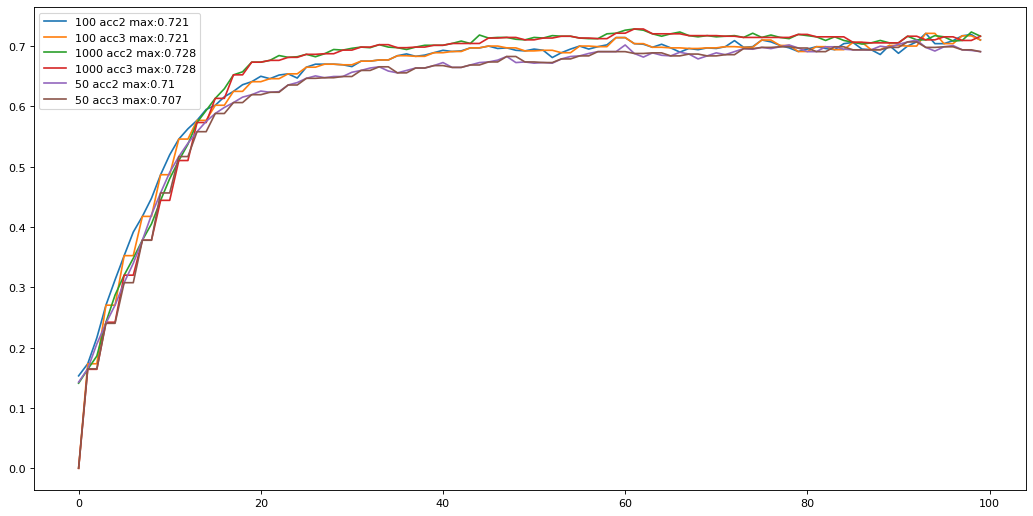

In [26]:
from matplotlib.pyplot import figure

figure(figsize=(16, 8), dpi=80)

plt.plot(range(len(acclist2)),acclist2,label='100 acc2 max:'+str(round(max(acclist2),3)))
plt.plot(range(len(acclist3)),acclist3,label='100 acc3 max:'+str(round(max(acclist3),3)))


plt.plot(range(len(acclist2000)),acclist2000,label='1000 acc2 max:'+str(round(max(acclist2000),3)))
plt.plot(range(len(acclist3000)),acclist3000,label='1000 acc3 max:'+str(round(max(acclist3000),3)))


plt.plot(range(len(acclist250)),acclist250,label='50 acc2 max:'+str(round(max(acclist250),3)))
plt.plot(range(len(acclist350)),acclist350,label='50 acc3 max:'+str(round(max(acclist350),3)))

plt.legend()